## This notebook calculates the average of the variables for the entire year of the states in  CONtinental USA.

In [1]:
## conda env Weather_Prediction

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr
import rioxarray ## what we need from rioxarray can be done using rio acessor
import regionmask

In [2]:
## lets load the data

data = xr.open_dataset("data_sfc.nc")
data

<xarray.Dataset> Size: 63MB
Dimensions:     (valid_time: 2920, latitude: 34, longitude: 79)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2010-01-01 ... 2010-12-31T21...
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Data variables:
    d2m         (valid_time, latitude, longitude) float32 31MB ...
    t2m         (valid_time, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
df=data.to_dataframe()
df

d2m         t2m
valid_time          latitude longitude                        
2010-01-01 00:00:00 48.75    -125.00    277.681854  279.335510
                             -124.25    276.716034  277.768127
                             -123.50    276.760956  277.172424
                             -122.75    276.804901  276.965393
                             -122.00    274.138885  274.655823
...                                            ...         ...
2010-12-31 21:00:00 24.00    -69.50     287.732727  295.728790
                             -68.75     287.549133  295.571564
                             -68.00     287.462219  295.528595
                             -67.25     287.574524  295.526642
                             -66.50     288.110657  295.060822

[7843120 rows x 2 columns]

In [4]:
## lets resamle the data to that of 1 Year
## that is, this is the 1 year average
year_avg = data.resample(valid_time='1YE').mean(dim='valid_time')
year_avg

<xarray.Dataset> Size: 22kB
Dimensions:     (valid_time: 1, latitude: 34, longitude: 79)
Coordinates:
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * valid_time  (valid_time) datetime64[ns] 8B 2010-12-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 11kB 280.2 ... 293.5
    t2m         (valid_time, latitude, longitude) float32 11kB 282.7 ... 297.4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
df=year_avg.to_dataframe()
df

d2m         t2m
valid_time latitude longitude                        
2010-12-31 48.75    -125.00    280.158722  282.717682
                    -124.25    279.476868  282.623596
                    -123.50    279.457245  283.005524
                    -122.75    279.182251  282.910004
                    -122.00    276.495148  280.681885
...                                   ...         ...
           24.00    -69.50     293.573669  297.577881
                    -68.75     293.532562  297.538727
                    -68.00     293.503845  297.490417
                    -67.25     293.475891  297.458191
                    -66.50     293.459106  297.428833

[2686 rows x 2 columns]

In [6]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
states_gdf = gpd.read_file(SHAPE_PATH)

states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [7]:
## removing alaska and other territories
## this step is not necessary as when merging will be done later, these territories will have NaN values
## which will be removed

state_gdf=states_gdf.drop([13,27, 36, 37, 38,42, 44, 45 ])

In [8]:
type(state_gdf)

geopandas.geodataframe.GeoDataFrame

In [9]:
state_list=state_gdf['NAME'].tolist()
print(len(state_list))
print(state_list[0])

48
Mississippi


In [10]:
def single_state(var):
    
    ''' Function to find the average value of weather data variables of a single state
        as listed in state_list.
         Args:
         --------
             var (str): The name of the state.

         Returns:
         --------
            final_df: Dataframe consisting of the columns in the shape file and corresponding value of the variables
                      which in this case is the d2m and t2m.
    '''
    
    states = state_gdf[state_gdf.NAME.isin([var])]
    state_mask = regionmask.mask_3D_geopandas(states,year_avg.longitude,year_avg.latitude)
    df_masked = year_avg.where(state_mask)
    summary = df_masked.groupby("region").mean(["latitude", "longitude","valid_time"])
    df2=summary.to_dataframe()   
    
    df = pd.merge(state_gdf, df2, left_index=True, right_index=True, how='left') 
    ## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
    ## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
    ## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

    final_df=df.dropna()
    return final_df

In [11]:
single_state(state_list[0])

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",284.287445,291.118561


In [12]:
## use the function to every state in the list of states
df_list=[]

for i in range(0,len(state_list)):
    df_list.append(single_state(state_list[i]))

df_list[:4] ## view first 4 in the list

[  STATEFP   STATENS     AFFGEOID GEOID STUSPS         NAME LSAD         ALAND  \
 0      28  01779790  0400000US28    28     MS  Mississippi   00  121533519481   
 
        AWATER                                           geometry         d2m  \
 0  3926919758  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  284.287445   
 
           t2m  
 0  291.118561  ,
   STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
 1      37  01027616  0400000US37    37     NC  North Carolina   00   
 
           ALAND       AWATER  \
 1  125923656064  13466071395   
 
                                             geometry         d2m         t2m  
 1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  281.780121  288.697479  ,
   STATEFP   STATENS     AFFGEOID GEOID STUSPS      NAME LSAD         ALAND  \
 2      40  01102857  0400000US40    40     OK  Oklahoma   00  177662925723   
 
        AWATER                                           geometry         d2m  \
 2  3374587997  POLYG

In [13]:
## test the constructed dataframe

df_list[1]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",281.780121,288.697479


In [14]:
## concetanete all the dataframe in the list

final_df=pd.concat(df_list)
final_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",284.287445,291.118561
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",281.780121,288.697479
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",280.990356,289.267578
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",279.872681,287.020050
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",278.584015,284.734833


In [15]:
type(final_df) ## note the type of dataframe is geopandas not pandas. The reasoning is mentioned in Cell 10.

geopandas.geodataframe.GeoDataFrame

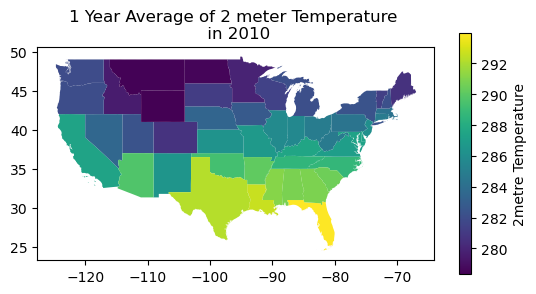

In [16]:
final_df.plot(column='t2m', legend=True, legend_kwds={"label": "2metre Temperature", 
                                                                               "shrink":0.65})
plt.title('1 Year Average of 2 meter Temperature \n in 2010')
plt.show()

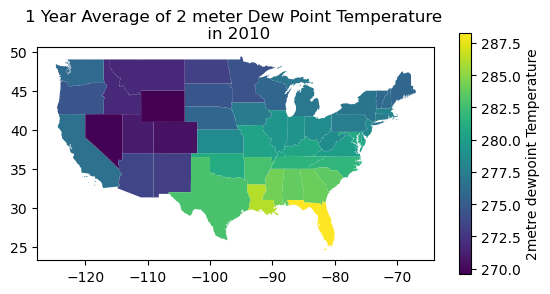

In [17]:
final_df.plot(column='d2m', legend=True, legend_kwds={"label": "2metre dewpoint Temperature", 
                                                                               "shrink":0.65})
plt.title('1 Year Average of 2 meter Dew Point Temperature \n in 2010')
plt.show()